<a href="https://colab.research.google.com/github/BrianDL/fisica_computacional/blob/main/3%20-%20Modelo%20de%20Ising/ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import asyncio
import numpy as np
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed


def calcular_energia(red, H, J):
    """
    Calcula la energía del sistema del modelo de Ising.

    Parámetros:
    red (np.array): Array 2D que representa la red de Ising
    H (float): Intensidad del campo magnético
    J (float): Fuerza de interacción

    Retorna:
    float: Energía total del sistema
    """
    L = red.shape[0]
    energia = 0
    magnetizacion = 0

    for i in range(L):
        for j in range(L):
            spin = red[i, j]
            vecinos = red[(i+1)%L, j] + red[i, (j+1)%L] + red[(i-1)%L, j] + red[i, (j-1)%L]

            energia += -J * spin * vecinos - H * spin
            magnetizacion += spin

    E = energia / 2  # Dividir por 2 para evitar contar dos veces
    M = magnetizacion / (L**2)

    return (E,M)

def calcular_magnetizacion(red):
  L = red.shape[0]
  return sum([ red[i][j] \
              for i in range(L) \
              for j in range(L) ]) / (L**2)

def calor_especifico(energias, beta, T):
  energias_cuadrado = [E**2 for E in energias]
  promedio_energias = np.mean(energias)

  return (beta/T)*(np.mean(energias_cuadrado) - promedio_energias**2)

def susceptibilidad(magnetizaciones, beta):
  magnetizaciones_cuadrado = [M**2 for M in magnetizaciones]
  promedio_magnetizaciones = np.mean(magnetizaciones)

  return beta * ( np.mean(magnetizaciones_cuadrado) - promedio_magnetizaciones**2 )

### Probamos la funcionalidad
L = 10  # Tamaño de la red
H = 0.1  # Intensidad del campo magnético
J = 1.0  # Fuerza de interacción

# Crear una red inicial aleatoria
red_inicial = np.random.choice([-1, 1], size=(L, L))

# Calcular energía y magnetización iniciales
energia_inicial, magnetizacion_inicial = calcular_energia(red_inicial, H, J)

assert magnetizacion_inicial == calcular_magnetizacion(red_inicial), "La magnetización debe ser la misma"

print(f"Energía inicial: {energia_inicial}")
print(f"Magnetización inicial: {magnetizacion_inicial}")



Energía inicial: -0.299999999999997
Magnetización inicial: 0.06


In [2]:
def metropolis_ising(L, H, J, beta, N, inicializacion='frio'):
    """
    Simula el modelo de Ising utilizando el algoritmo de Metropolis.

    Parámetros:
    L (int): Longitud de la red
    H (float): Intensidad del campo magnético
    J (float): Fuerza de interacción
    beta (float): Temperatura inversa (1/T)
    N (int): Número de pasos de Monte Carlo a realizar
    inicializacion (str): Tipo de inicialización ('frio' o 'caliente')

    Retorna:
    tuple: (energias, magnetizaciones, red_final)
    """
    ### Inicializar la red
    assert inicializacion in ('frio', 'caliente'), \
      "La inicialización debe ser en 'frio' o 'caliente' "

    red = np.ones((L, L)) if inicializacion == 'frio' else \
      np.random.choice([-1, 1], size=(L, L))  # Configuración aleatoria


    ### Variables a devolver
    energias = []
    magnetizaciones = []

    t=0
    energia, magnetizacion = calcular_energia(red, H, J)

    while t<N:

        for _ in range(L*L):  # Un paso de Monte Carlo es L*L intentos de flip
            # Seleccionar un sitio al azar
            i, j = np.random.randint(0, L, 2)

            # Calcular el cambio de energía si se invierte el spin
            vecinos = red[(i+1)%L, j] + red[i, (j+1)%L] + red[(i-1)%L, j] + red[i, (j-1)%L]
            delta_E = 2 * J * red[i, j] * vecinos + 2 * H * red[i, j]

            # delta_M = -2*red[i,j] / (L**2)

            # Decidir si aceptar o rechazar el cambio
            aceptar = delta_E <= 0 \
              or np.random.random() < np.exp(-beta * delta_E)

            if not aceptar: continue
            red[i, j] *= -1

            # Calcular y almacenar la energía y magnetización para cada configuración aceptada
            energia += delta_E
            # magnetizacion += delta_M


        energias.append(energia)
        magnetizaciones.append(calcular_magnetizacion(red))

        t+=1


    return energias, magnetizaciones, red

async def async_metropolis_ising(loop, exe, *args):
  result = await loop.run_in_executor(exe, metropolis_ising, *args)
  return result



In [3]:

L = 10  # Tamaño de la red
H = 0.0  # Intensidad del campo magnético
J = 1.0  # Fuerza de interacción
N = 2**13  # Número de pasos de Monte Carlo

params = [ (S,T) for S in ['frio', 'caliente'] for T in (0.1, 3, 100) ]

loop = asyncio.get_event_loop()

t0 = time.time()
with ProcessPoolExecutor(max_workers=8) as exe:
  results = await asyncio.gather(*[
      async_metropolis_ising(loop, exe, L, H, J, 1/T, N, S) \
      for S,T in params
  ])
  params_a_result = {p:R for p,R in zip(params, results)}

print(f"Todas las simulaciones con N={N} tomaron {time.time() - t0} s.")

Todas las simulaciones con N=8192 tomaron 71.76797413825989 s.


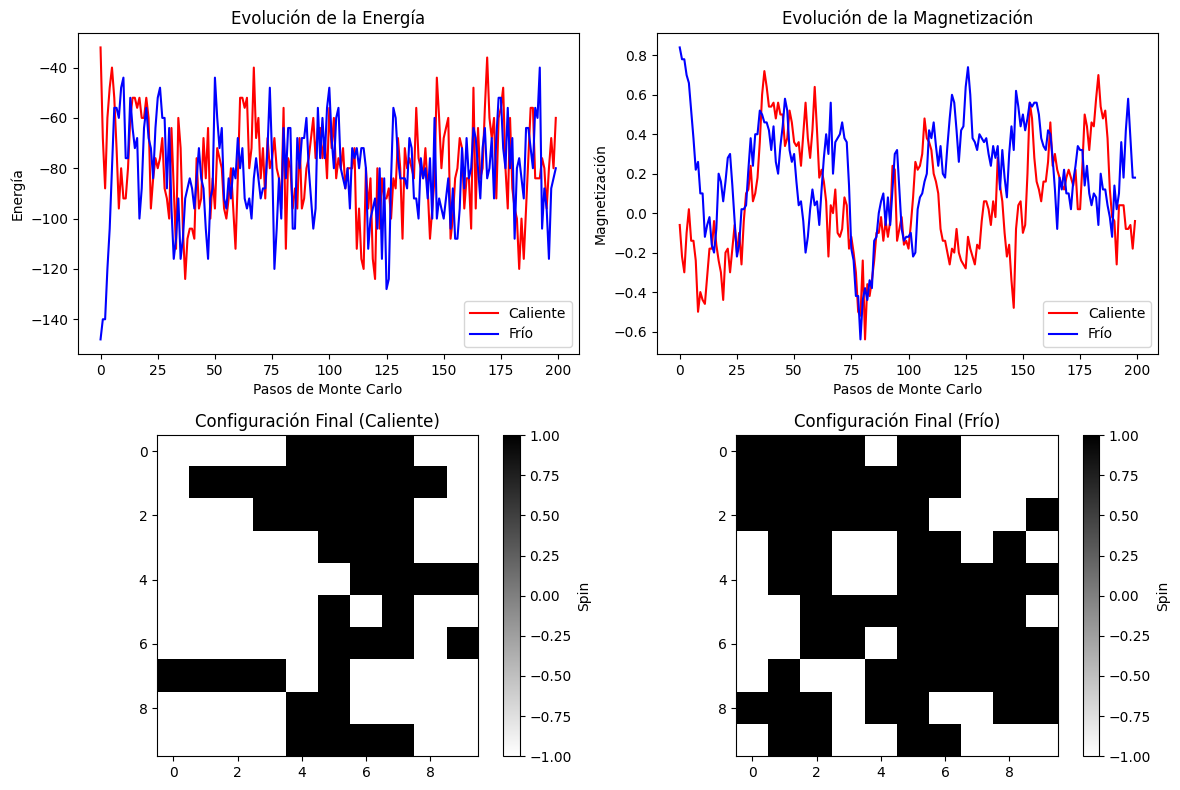

In [4]:
# Visualización de los resultados
import matplotlib.pyplot as plt

# print(result)

T = 3 ### temperatura que nos interesa graficar

energias_frio, magnetizaciones_frio, red_final_frio = params_a_result[('frio', T)]
energias_caliente, magnetizaciones_caliente, red_final_caliente = params_a_result[('caliente', T)]

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.plot(energias_caliente[:200], label='Caliente', color='r')
plt.plot(energias_frio[:200], label='Frío', color='b')
plt.title("Evolución de la Energía")
plt.xlabel("Pasos de Monte Carlo")
plt.ylabel("Energía")
plt.legend()

plt.subplot(222)
plt.plot(magnetizaciones_caliente[:200], label='Caliente', color='r')
plt.plot(magnetizaciones_frio[:200], label='Frío', color='b')
plt.title("Evolución de la Magnetización")
plt.xlabel("Pasos de Monte Carlo")
plt.ylabel("Magnetización")
plt.legend()

plt.subplot(223)
plt.imshow(red_final_caliente, cmap='binary')
plt.title("Configuración Final (Caliente)")
plt.colorbar(label='Spin')

plt.subplot(224)
plt.imshow(red_final_frio, cmap='binary')
plt.title("Configuración Final (Frío)")
plt.colorbar(label='Spin')

plt.tight_layout()
plt.show()

In [5]:
for params, result in sorted(params_a_result.items()):
  S,T = params
  Es, Ms, red = result

  beta = 1.0/T

  C = calor_especifico(Es, beta, T)
  X = susceptibilidad(Ms, beta)

  print(f"Para {T:.{2}f} inicializada en {S}: C = {C:.{2}f}; X = {X:.{2}f}")

Para 0.10 inicializada en caliente: C = 513.97; X = 0.00
Para 3.00 inicializada en caliente: C = 43.64; X = 0.04
Para 100.00 inicializada en caliente: C = 0.02; X = 0.00
Para 0.10 inicializada en frio: C = 0.00; X = 0.00
Para 3.00 inicializada en frio: C = 44.83; X = 0.04
Para 100.00 inicializada en frio: C = 0.02; X = 0.00


In [20]:
### Definimos una función para aplicar el algoritmo de metrópolis en un rango de
### temperaturas, pedimos un acumulador para almacenar los resultados

async def applicar_en_rtemp(temps, acc, pasos=10, L=10, H=0, J=1.0, N=2**13):
  loop = asyncio.get_event_loop()
  with ProcessPoolExecutor(max_workers=8) as exe:
    results = await asyncio.gather(*[
        async_metropolis_ising(loop, exe, L, H, J, 1/T, N) \
        for T in temps
    ])
    acc.update({t:R for t,R in zip(temps, results)})


In [7]:
### Definimos esto en su propia celda para poder acumular los
### resultados de diferentes corridas si es necesario.
temp_a_result = {} ### para almacenar los resultados

In [13]:
### Para encontrar el punto crítico, notamos que la susceptibilidad
### tiene ceros en los puntos extremos de la temperatura, por lo que
### debe tener al menos un máximo en el intérvalo. Este enfoque nos lo
### confirma una de las respuestas en:
### https://mattermodeling.stackexchange.com/questions/3930/ising-model-how-can-i-spot-the-critical-point

### Generaremos un rango de temperaturas en entre 1 y 3, con pasos cada vez más precisos
### en la vecindad del valor crítico teórico
# temps = [
#     T for i in range(11) \
#     if (T:= 1+i/(0.5*10.0))
#     ]

# temps += [
#     T for i in (1,2) for j in range(11) \
#     if (T:= 2+j/(i*10.0)) not in temps
#     ]

temps += [
    T for i in (4,8) for j in range(11) \
    if (T:= 2.25+j/(i*10.0)) not in temps
    ]

print(f"Num. Simulaciones: {len(temps)}")

t0 = time.time()
await applicar_en_rtemp(temps, temp_a_result)
print(f"Las {len(temps)} simulaciones tomaron {time.time() - t0} s.")

Num. Simulaciones: 37
Las 37 simulaciones tomaron 368.6825385093689 s.


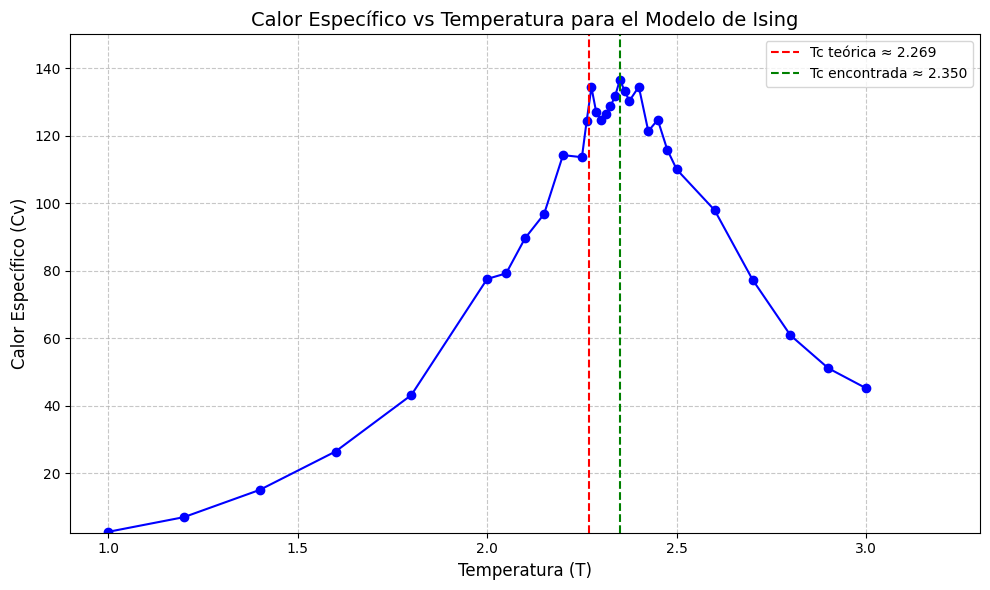

In [18]:
temp_a_sus = { T: susceptibilidad(res[1], 1/T) for T, res in temp_a_result.items() }
temp_a_cv = {T: calor_especifico(res[0], 1/T, T) for T, res in temp_a_result.items() }


import matplotlib.pyplot as plt

def graficar_susceptibilidad(temp_a_sus):
    """
    Grafica la susceptibilidad magnética vs temperatura.

    :param temp_a_sus: Diccionario con temperaturas como claves y susceptibilidades como valores
    """
    # Ordenar el diccionario por temperatura para asegurar que la gráfica esté en orden
    datos_ordenados = sorted(temp_a_sus.items())
    temperaturas, susceptibilidades = zip(*datos_ordenados)

    # Encontrar la temperatura con la susceptibilidad máxima
    temp_max_sus = max(temp_a_sus, key=temp_a_sus.get)
    max_sus = temp_a_sus[temp_max_sus]

    plt.figure(figsize=(10, 6))
    plt.plot(temperaturas, susceptibilidades, 'b-', marker='o')
    # plt.semilogy(temperaturas, susceptibilidades, 'b-', marker='o')
    plt.xlabel('Temperatura (T)', fontsize=12)
    plt.ylabel('Calor Específico (Cv)', fontsize=12)
    plt.title('Calor Específico vs Temperatura para el Modelo de Ising', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Agregar un poco de espacio a los ejes x e y
    plt.xlim(min(temperaturas) * 0.9, max(temperaturas) * 1.1)
    plt.ylim(min(susceptibilidades) * 0.9, max(susceptibilidades) * 1.1)

    # Agregar línea para la temperatura crítica teórica
    temp_critica_teorica = 2.269  # Temperatura crítica teórica para el modelo de Ising 2D
    plt.axvline(x=temp_critica_teorica, color='r', linestyle='--',
                label=f'Tc teórica ≈ {temp_critica_teorica:.3f}')

    # Agregar línea para la temperatura de máxima susceptibilidad encontrada
    plt.axvline(x=temp_max_sus, color='g', linestyle='--',
                label=f'Tc encontrada ≈ {temp_max_sus:.3f}')

    # Texto para la temperatura crítica teórica
    # plt.text(temp_critica_teorica * 1.05, plt.ylim()[1] * 0.9, f'Tc teórica ≈ {temp_critica_teorica:.3f}',
    #          rotation=90, verticalalignment='top', color='r')

    # Texto para la temperatura de máxima susceptibilidad encontrada
    # plt.text(temp_max_sus * 1.05, plt.ylim()[1] * 0.9, f'Tc encontrada ≈ {temp_max_sus:.3f}',
    #          rotation=90, verticalalignment='top', color='g')

    plt.legend()
    plt.tight_layout()
    plt.show()


graficar_susceptibilidad(temp_a_cv)

In [23]:
### Vamos a acumular esta vez resultados cerca del valor crítico de la temperatura
Tc = 2.269
temps = [
    Tc - n*(0.01) for n in range(-50,51,10)
]

print(f"Num. Simulaciones: {len(temps)}")
t0 = time.time()
await applicar_en_rtemp(temps, temp_a_result)
print(f"Las {len(temps)} simulaciones tomaron {time.time() - t0} s.")

Num. Simulaciones: 11
Las 11 simulaciones tomaron 120.31140565872192 s.
